In [1]:
# Import libraries
import numpy as np
import geopandas as gpd
import momepy
import time
import copy
import networkx as nx
# import pandas as pd
# import shapely
# import shapely.geometry as sg
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline


In [2]:
map_am = gpd.read_file("Sidewalk_width_crossings_smaller.geojson")

# Objectives
objective1 = map_am['length']
objective2 = map_am['crossing']
objective3 = map_am['obstacle_free_width']

objectives = ('length', 'crossing')

In [3]:
# Create a NetworkX graph from the map
G = momepy.gdf_to_nx(map_am, approach='primal')
nodes = G.nodes
edges = G.edges
# print(G)

/usr/local/anaconda3/envs/test/lib/python3.10/site-packages/momepy/utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [4]:
# print(nodes)

In [5]:

S = (122245.37633330293, 486126.8581684635) #very first node
T = (122320.31466476223, 486327.5294561802)

In [6]:
def pareto_dominates(a, b):
    """Check if the vector in b Pareto dominates vector a.

    Note: The original code has been modified to work for our minimization problem.

    Args:
        a (ndarray): A numpy array.
        b (ndarray): A numpy array.

    Returns:
        bool: Whether vector b dominates vector a.
    """
    a = np.array(a)
    b = np.array(b)
    return np.all(a <= b) and np.any(a < b)


def p_prune(candidates):
    """Create a Pareto coverage set from a set of candidate points.

    References:
        .. [1] Roijers, D. M., & Whiteson, S. (2017). Multi-objective decision making. 34, 129–129.
            https://doi.org/10.2200/S00765ED1V01Y201704AIM034

    Args:
        candidates (Set[Tuple]): A set of vectors.

    Returns:
        Set[Tuple]: A Pareto coverage set.
    """
    pcs = set()
    while candidates:
        vector = candidates.pop()

        for alternative in candidates:
            if pareto_dominates(alternative, vector):
                vector = alternative

        to_remove = set(vector)
        for alternative in candidates:
            if pareto_dominates(vector, alternative):
                to_remove.add(alternative)

        candidates -= to_remove
        pcs.add(vector)
    return pcs


def pvi(G, T, objectives, max_iter=30):
    start = time.time()
    nd_vectors = [set([tuple(np.full(2, np.inf)) for _ in range(len(G.nodes))]) for _ in range(len(G.nodes))] # Initialisation of nodes
    j = 0

    for n, current_node in enumerate(G.nodes):
        if current_node == T:  # We've reached the terminal state
            nd_vectors[n] = set([(0, 0) for _ in G.nodes])
            break

    # nd_vectors_update = copy.deepcopy(nd_vectors)

    # for run in range(max_iter):  # We execute the algorithm for a number of iterations.
    #     print(f'Value Iteration number: {run}')

    # while '{(inf, inf)}' in str(nd_vectors_update):
    # converged = False
    # while not converged:  # Run until convergence
    #     converged = True
    while True:
        old_vectors = copy.deepcopy(nd_vectors)
        for n, current_node in enumerate(G.nodes):  # Loop over all states. Note: current_node is an object; n=number
            if current_node == T:
                continue

            for nk, neighbor in enumerate(G.nodes): #Note: neighbor is an object; k=number

                if neighbor not in G.neighbors(current_node):
                    continue

                edge = G[current_node][neighbor]
                edge_list = [v for k, v in edge.items()]  # Stores only the values of the edges' properties

                cost = []
                for i in objectives:
                  cost.append(edge_list[0][i])
                # print(f"cost:{cost}")
                cost = np.array(cost)
                results = nd_vectors[n].copy()

                for value_vec in nd_vectors[nk]:
                    # for value_vec in v_list:
                    # if value_vec != (np.inf, np.inf):
                    #     print("value vec:", value_vec)
                    results.add(tuple(cost+value_vec)) # The set of candidate vectors
                # print(f"results:{results}")

                results = p_prune(results)
                # print(f"results pruned:{results}")

                # if nd_vectors[n][nk] != results:
                #     converged = False
                nd_vectors[n] = results
                # print(f"nd_vectors:{nd_vectors}")


        j += 1
        # if has_converged(nd_vectors, old_vectors, 0.0001):
        #     break
        if nd_vectors == old_vectors:
            break
        # Check for convergence
        # if delta < 0.0001:
        #     break

        # if converged:
        #     break

        nd_vectors = copy.deepcopy(nd_vectors)  # Else perform a deep copy and go again.

    print(f'Iterations: {j}')
    end = time.time()
    elapsed_seconds = (end - start)
    print("Seconds elapsed: " + str(elapsed_seconds))

    return nd_vectors

# def has_converged(nd_vectors, old_vectors, epsilon):
#     for i in range(len(nd_vectors)):
#         # for j in range(len(nd_vectors[i])):
#         if not np.allclose(list(nd_vectors[i])[0], list(old_vectors[i])[0], atol=epsilon):
#             return False
#     return True

pvi_result = pvi(G, T, objectives)
print(pvi_result)


Iterations: 21
Seconds elapsed: 0.5991470813751221
[{(284.05000000000007, 4.0)}, {(274.06000000000006, 4.0)}, {(264.07000000000005, 4.0)}, {(254.08000000000004, 4.0)}, {(244.09000000000003, 4.0)}, {(243.08000000000004, 4.0)}, {(246.43000000000004, 4.0)}, {(251.37000000000003, 4.0)}, {(256.42, 4.0)}, {(257.94000000000005, 4.0)}, {(267.93000000000006, 4.0)}, {(277.9200000000001, 4.0)}, {(222.86, 3.0)}, {(232.85000000000002, 3.0)}, {(242.84000000000003, 3.0)}, {(252.83000000000004, 3.0)}, {(262.82000000000005, 3.0)}, {(201.74, 3.0)}, {(208.76000000000002, 3.0)}, {(224.96000000000004, 3.0)}, {(214.97000000000003, 3.0)}, {(204.98000000000002, 3.0)}, {(232.04000000000005, 3.0)}, {(195.06, 2.0)}, {(185.07, 2.0)}, {(179.9, 2.0)}, {(192.63000000000002, 2.0)}, {(190.73000000000002, 2.0)}, {(184.03, 2.0)}, {(190.91000000000003, 2.0)}, {(180.74, 2.0)}, {(178.74, 2.0)}, {(168.22, 2.0)}, {(178.21, 2.0)}, {(184.33, 2.0)}, {(186.46, 2.0)}, {(189.08, 2.0)}, {(179.09, 2.0)}, {(176.9, 2.0)}, {(193.060000

[9.99 0.  ] [(122254.86602688645, 486129.80052856216), (122264.35426393585, 486132.74411788705), (122273.84081337851, 486135.69101398275), (122283.19823912054, 486138.9678026403), (122284.1816391946, 486139.19731384714), (122293.35529070727, 486160.70100324217), (122290.30564961619, 486170.1963395323), (122243.05065852, 486228.52578009496), (122246.10058319086, 486224.512771215), (122237.33719104923, 486218.1490745187), (122246.77932030056, 486223.5791244763), (122254.17297428084, 486206.4873344737), (122256.36390748693, 486206.6132239499), (122259.39867920603, 486198.8810344641), (122258.88243648612, 486260.58853595395), (122282.69556966702, 486193.2948693236), (122279.36739295325, 486202.70485648955), (122276.034562429, 486212.11332275654), (122193.16766388352, 486245.76383735583), (122202.72350389507, 486248.5676793542), (122212.27910424495, 486251.3717500277), (122221.83465940144, 486254.17523497797), (122231.39010150469, 486256.97849734355), (122245.6907597802, 486294.2355461444),

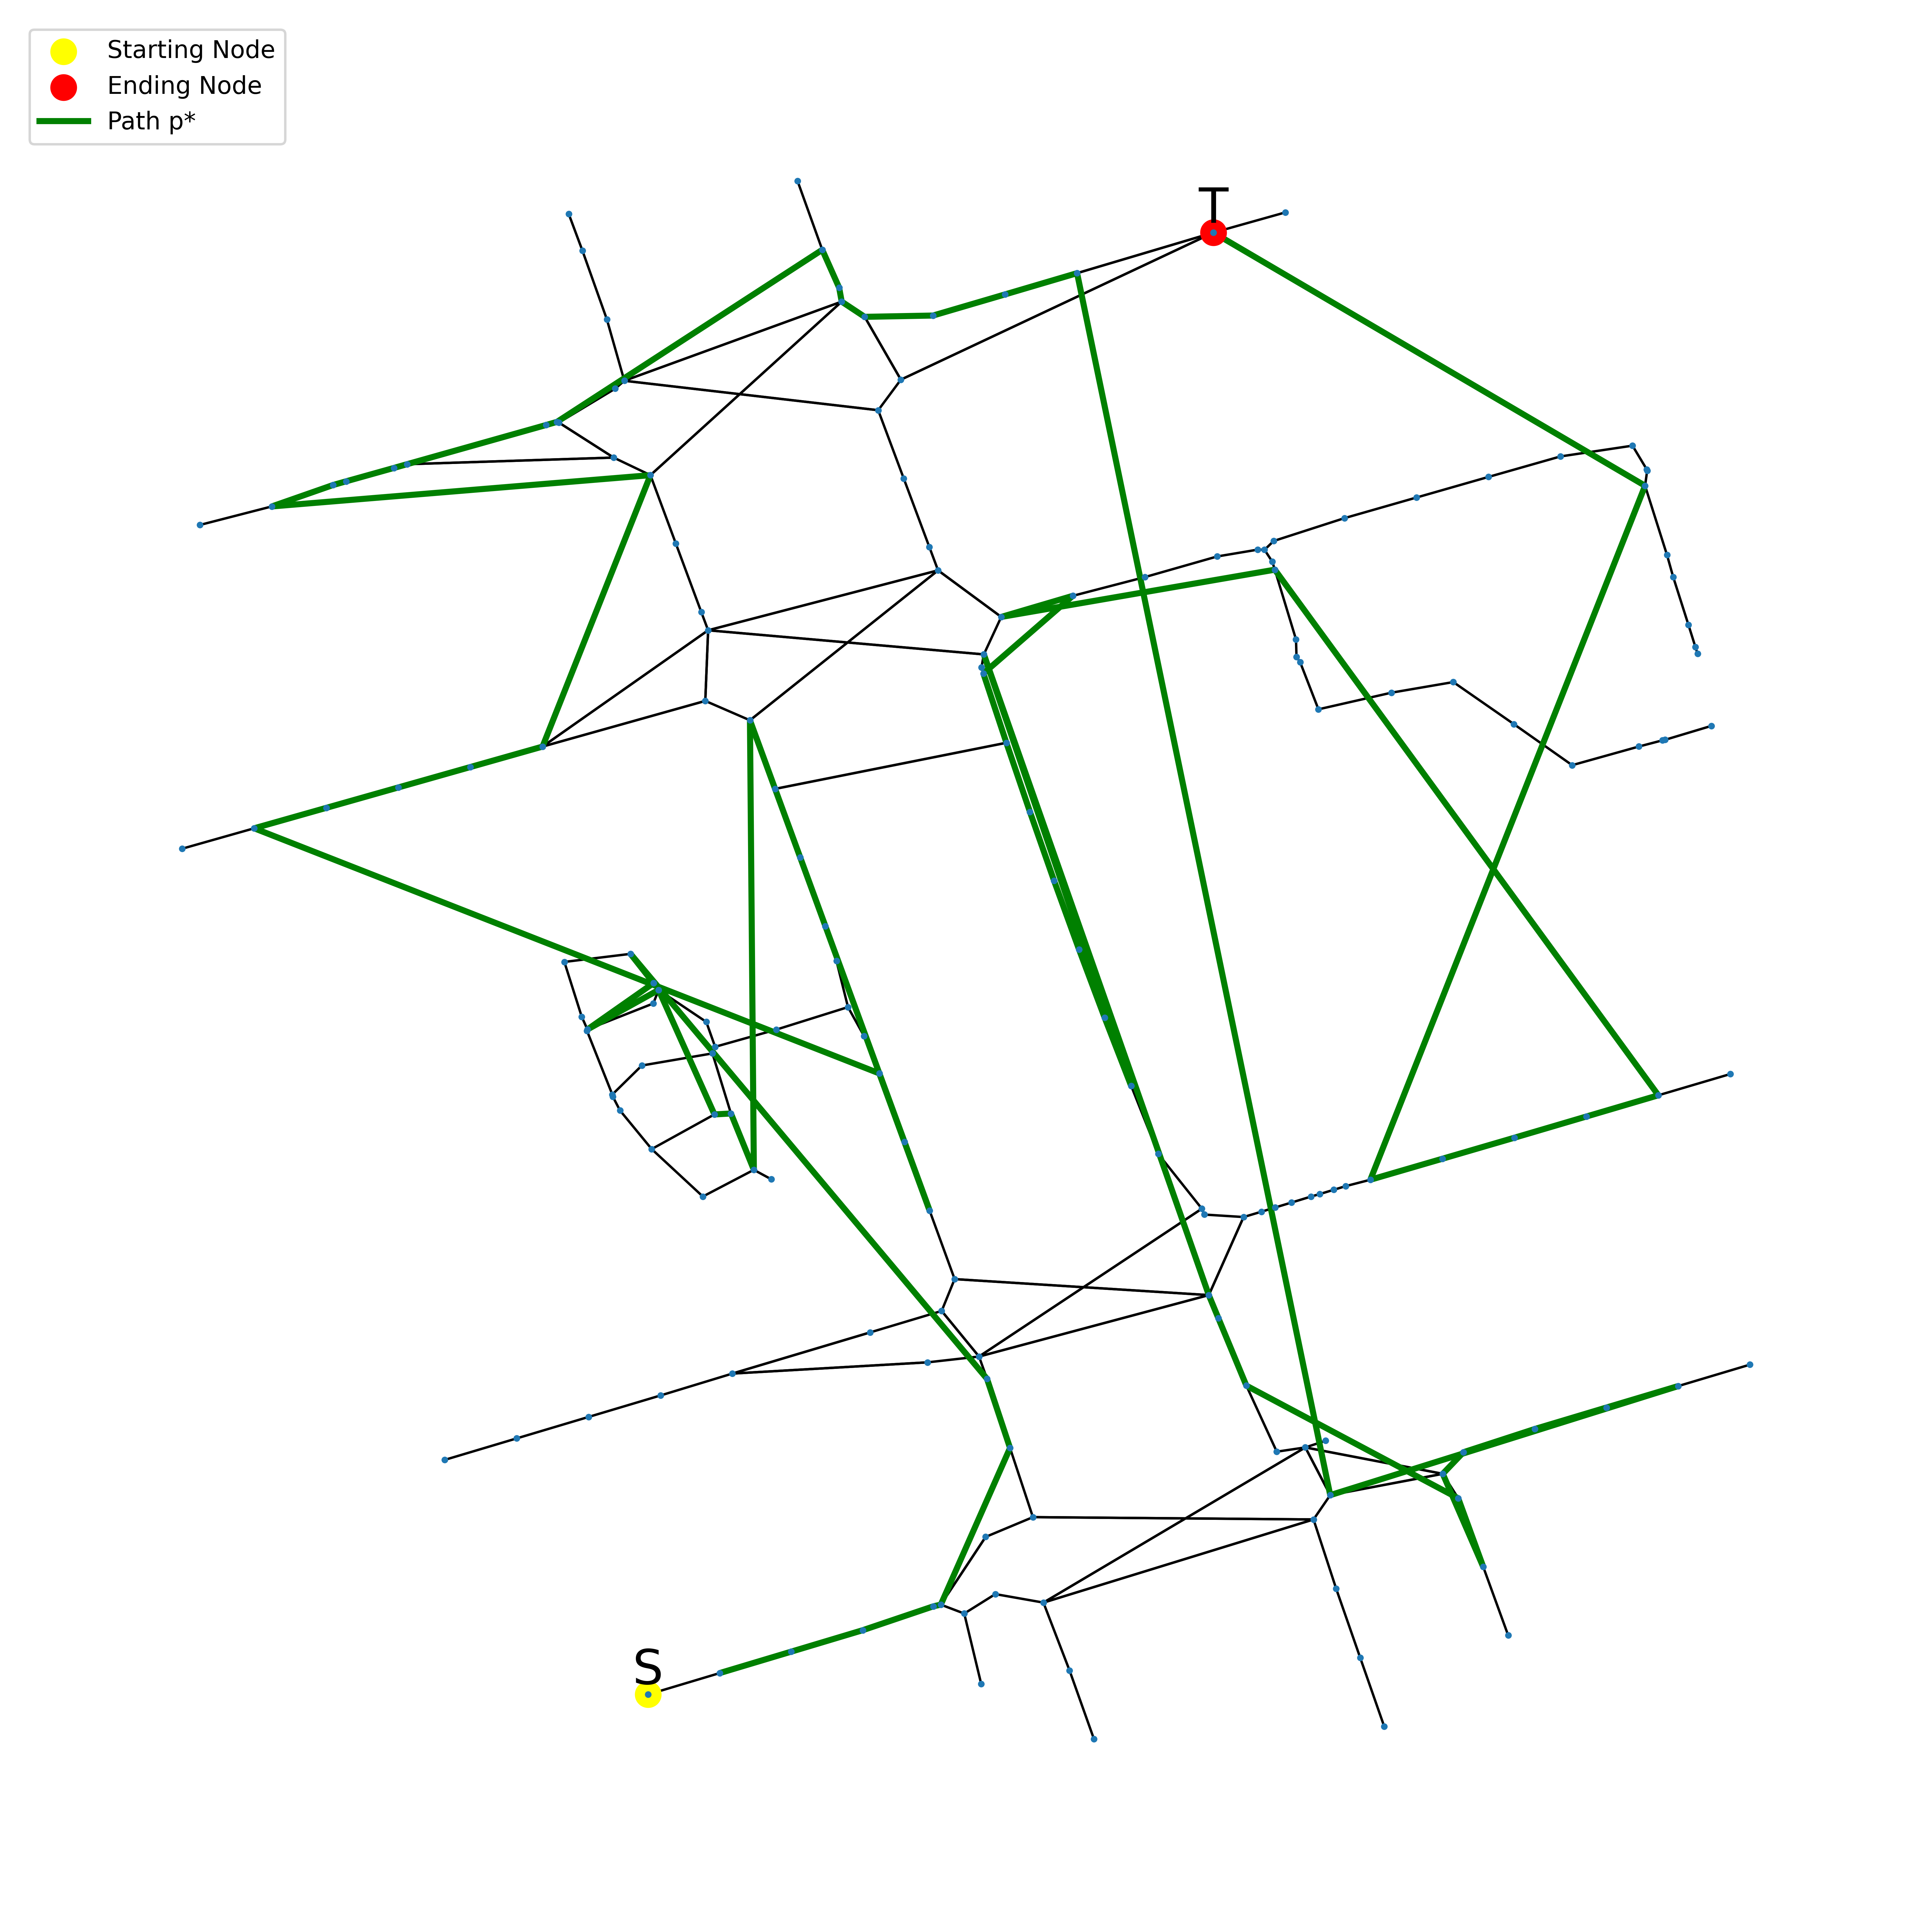

In [9]:
from matplotlib import colors


def track_policy(G, S, T, vec, pvi_vec, tol=1e-8):
        """Track a policy from its return vector.

        Args:
            vec (array_like): The return vector to track.
            env (gym.Env): The environment to track the policy in.
            tol (float, optional): The tolerance for the return vector. (Default value = 1e-3)
        """
        target = np.array(vec)  # SET THE TARGET YOU WANT TO ACQUIRE. SO IN YOUR CASE THIS IS THE VECTOR BELONGING TO THE OPTIMAL PATH.
        path = []  # START THE “PATH” AT THE START NODE HERE.
        terminated = False  # WHETHER WE ARE AT THE TERMINAL NODE.
        total_rew = np.zeros(2)  # THE REWARD WE HAVE ACCUMULATED SO FAR IN THE PATH
        im_rew = np.zeros(2)

        for n, current_node in enumerate(G.nodes):
            if current_node == T:
                # total_rew += im_rew
                path.append(current_node)
                break
            else:  # WHILE WE DO NOT REACH THE GOAL NODE.
                closest_dist = np.inf  # THIS IS THE DISTANCE TO THE CLOSEST VALUE VECTOR WE CAN GET
                closest_action = 0  # THIS IS THE ACTION, I.E. FOR YOU THE NEIGHBOUR, THAT WE MUST GO WITH TO MOVE ALONG THE CORRECT PATH.
                found_action = False  # WHETHER WE THINK WE FOUND THE CORRECT NEIGHBOUR.
                new_target = target   # THE NEW TARGET

                for nk, action in enumerate(G.neighbors(current_node)):  # THIS CHECKS OVER THE POSSIBLE OPTIONS YOU CAN DO. FOR YOU THIS WOULD BE THE NEIGHBOURS OF YOUR CURRENT STATE.

                    # CHECK WHAT COST IS ASSOCIATED WITH THE EDGE BETWEEN YOUR CURRENT NODE AND THE NEIGHBOUR.
                    edge = G[current_node][action]
                    edge_list = [v for k, v in edge.items()]  # Stores only the values of the edges' properties

                    im_rew = np.array([edge_list[0]['length'], edge_list[0]['crossing']])
                    # print(f"im_rew:{im_rew}")
                    non_dominated_set = pvi_vec[n]  # GET THE NON DOMINATED SET FROM PVI AT THIS NODE-NEIGHBOUR

                    for q in non_dominated_set:  # CHECK FOR EVERY VECTOR IN THIS SET
                        q = np.array(q)
                        dist = np.sum(np.abs(q + im_rew - target))  # CHECK THE DISTANCE BETWEEN YOUR TARGET (SO WHAT YOU STILL NEED TO GET) AND THE VALUE VECTOR
                        if dist < closest_dist:  # IF THE DISTANCE IS BETTER THAN WHAT YOU GOT SO FAR.
                            closest_dist = dist  # SET THIS DISTANCE AS THE BEST DISTANCE.
                            closest_action = action  # TAKE THE ACTION.
                            new_target = q  # UPDATE THE TARGET (I.E. REMOVE THE IMMEDIATE COST)
                            # print(new_target)
                            if dist < tol:  # IF THE DISTANCE IS GOOD ENOUGH.
                                found_action = True  # JUST SAY YOU FOUND THE CORRECT NEIGHBOUR
                                path.append(current_node)
                                # print("current_node", current_node)
                                break  # AND STOP THE LOOP


                    if found_action:
                        # path.append(closest_action)
                        break

                current_node = closest_action  # TAKE THE EDGE THAT YOU THINK IS BEST
                # edge2 = G[closest_action][current_node]
                total_rew = im_rew # UPDATE THE REWARD YOU ACQUIRED from tracking the policy and should equal the target vector in the end
                target = new_target  # UPDATE THE TARGET
                # if current_node not in path:
                #     path.append(current_node)


        return total_rew, path  # YOU HAVE TO RETURN THE TRAVERSED PATH HERE AS WELL


res, pathh = track_policy(G, S, T, (284.05,4.), pvi_result)
print(res, pathh)

# Legend
legend_text = []
legend_labels = []
# Colors
cmap = matplotlib.colormaps['tab10']  # Colormap
exclude_colors = ['green', 'blue']
new_cmap = [color for color in cmap.colors if color not in exclude_colors]
new_cmap = colors.ListedColormap(new_cmap)
# Plot
fig, ax = plt.subplots(figsize=(14, 14), dpi=600)
# All nodes and edges
nx.draw(G, {n: [n[0], n[1]] for n in list(G.nodes)}, ax=ax, node_size=3)

# Color p* in green
p_star_edges = list(zip(pathh[:-1], pathh[1:]))
green_p_star = 'green'
green_p_star_lwidth = 2.5   # Line width
legend_label = f"Path p*"
nx.draw_networkx_edges(G, pos={n: [n[0], n[1]] for n in list(G.nodes)}, edgelist=p_star_edges, ax=ax,
                       edge_color=green_p_star, width=green_p_star_lwidth)
legend_text.append(
    plt.Line2D([], [], color=green_p_star, linestyle='-', linewidth=green_p_star_lwidth, label=legend_label))
legend_labels.append(legend_label)

# Start & end node
ax.scatter(S[0], S[1], c='yellow', marker='o', s=100, label='Starting Node')
ax.scatter(T[0], T[1], c='red', marker='o', s=100, label='Terminating Node')
ax.text(S[0], S[1], 'S', fontsize=20, ha='center', va='bottom')
ax.text(T[0], T[1], 'T', fontsize=20, ha='center', va='bottom')
start_text = plt.scatter([], [], c='yellow', marker='o', s=100)
end_text = plt.scatter([], [], c='red', marker='o', s=100)
start_label = 'Starting Node'
end_label = 'Ending Node'

# Create legend
all_handles = [start_text, end_text] + legend_text
all_labels = [start_label, end_label] + legend_labels
ax.legend(handles=all_handles, labels=all_labels)
ax.legend(handles=all_handles, labels=all_labels, loc='upper left')

# Save the image
folder_path = 'experiments'
file_name = 'ex71.png'
file_path = folder_path + '/' + file_name
plt.savefig(file_path, bbox_inches='tight')


In [6]:


def track_policy(G, S, T, target, pvi_vec, tol=1e-3):

        terminated = False
        truncated = False
        reward = np.zeros(2)
        path = []

        while not (terminated or truncated):
            closest_dist = np.inf
            closest_action = 0
            found_action = False
            new_target = target

            for n, current_node in enumerate(G.nodes):
                if current_node == T:
                    terminated = True
                    truncated = True
                else:
                    for nk, neighbor in enumerate(G.neighbors(current_node)):
                        im_rew = [n, nk]
                        # print(f"im_rew:{im_rew}")
                        non_dominated_set = pvi_vec[n]
                        # print(f"non_dominated set:{non_dominated_set}")

                        for q in non_dominated_set:
                            q = np.array(q)
                            # print(f"q:{q}")
                            dist = np.sum(np.abs(q + im_rew - target))
                            # print(f"distance:{dist}")
                            if dist < closest_dist:
                                closest_dist = dist
                                closest_action = nk
                                new_target = q

                                if dist < tol:
                                    found_action = True
                                    break

                        if found_action:
                            break

                #closest action = edge you want to take
                #step = go to neighbor node
                # closest_action = nk
                reward = im_rew
                target = new_target
                if current_node not in path:
                    path.append(current_node)

        return reward, path

res, path = track_policy(G, S, T, (284.05,4.), pvi_result)
print(path)
#ANSWER:
#Target [284.05   4.  ]
# Path [(122245.37633330293, 486126.8581684635), (122254.86602688645, 486129.80052856216), (122264.35426393585, 486132.74411788705), (122273.84081337851, 486135.69101398275), (122283.19823912054, 486138.9678026403), (122284.1816391946, 486139.19731384714), (122290.12705889999, 486148.4950394649), (122296.3898333376, 486151.2069021054), (122293.35529070727, 486160.70100324217), (122290.30564961619, 486170.1963395323), (122289.24584929895, 486173.25169782597), (122284.2947638598, 486179.51092348614), (122286.01308887315, 486183.8814735307), (122282.69556966702, 486193.2948693236), (122279.36739295325, 486202.70485648955), (122276.034562429, 486212.11332275654), (122274.00277185065, 486217.2508821529), (122271.878266905, 486221.2167929504), (122270.35144282578, 486227.55055625446), (122268.87098268993, 486232.3355880248), (122265.53626116004, 486241.7517373523), (122262.21512810217, 486251.1722638347), (122258.88243648612, 486260.58853595395), (122283.81709680714, 486281.1675979253), (122282.66333889941, 486284.36990515806), (122279.27332236386, 486293.76013232773), (122275.88338278513, 486303.1505475647), (122278.88553626387, 486307.3430291897), (122320.31466476223, 486327.5294561802)] with cost [array([284.05,   4.  ])]
# Alternative path 1: [(122245.37633330293, 486126.8581684635), (122254.86602688645, 486129.80052856216), (122264.35426393585, 486132.74411788705), (122273.84081337851, 486135.69101398275), (122283.19823912054, 486138.9678026403), (122284.1816391946, 486139.19731384714), (122287.28805009159, 486137.97386694513), (122291.40829399273, 486140.643590483), (122297.7854183222, 486139.47700177913), (122332.49987764945, 486160.7773385103), (122328.7127865793, 486160.19348477497), (122324.68334361241, 486169.2581765358), (122320.97320132754, 486178.5199137332), (122319.70610252809, 486181.6875618371), (122286.01308887315, 486183.8814735307), (122282.69556966702, 486193.2948693236), (122279.36739295325, 486202.70485648955), (122276.034562429, 486212.11332275654), (122274.00277185065, 486217.2508821529), (122271.878266905, 486221.2167929504), (122270.35144282578, 486227.55055625446), (122268.87098268993, 486232.3355880248), (122265.53626116004, 486241.7517373523), (122262.21512810217, 486251.1722638347), (122258.88243648612, 486260.58853595395), (122283.81709680714, 486281.1675979253), (122282.66333889941, 486284.36990515806), (122279.27332236386, 486293.76013232773), (122275.88338278513, 486303.1505475647), (122278.88553626387, 486307.3430291897), (122320.31466476223, 486327.5294561802)]


[(122245.37633330293, 486126.8581684635), (122254.86602688645, 486129.80052856216), (122264.35426393585, 486132.74411788705), (122273.84081337851, 486135.69101398275), (122283.19823912054, 486138.9678026403), (122284.1816391946, 486139.19731384714), (122287.28805009159, 486137.97386694513), (122291.40829399273, 486140.643590483), (122289.53424561612, 486128.31132216856), (122297.7854183222, 486139.47700177913), (122301.24255780602, 486130.1701925009), (122304.47424118801, 486120.76208520425), (122256.54763350038, 486170.91398380254), (122247.04588395767, 486167.91526857053), (122237.50744934028, 486164.9669819529), (122227.969152229, 486162.0189639581), (122218.43104837791, 486159.0709819753), (122289.24584929895, 486173.25169782597), (122282.43320919861, 486172.4559260068), (122296.3898333376, 486151.2069021054), (122293.35529070727, 486160.70100324217), (122290.30564961619, 486170.1963395323), (122290.12705889999, 486148.4950394649), (122234.28219718198, 486227.4182083386), (122243.0

In [7]:
#ALTERNATIVE CODE I TRIED
def track_policy(G, S, T, vec, pvi_vec, tol=1e-3):
        """Track a policy from its return vector.

        Args:
            vec (array_like): The return vector to track.
            env (gym.Env): The environment to track the policy in.
            tol (float, optional): The tolerance for the return vector. (Default value = 1e-3)
        """
        target = np.array(vec)  # SET THE TARGET YOU WANT TO ACQUIRE. SO IN YOUR CASE THIS IS THE VECTOR BELONGING TO THE OPTIMAL PATH.
        path = [S]  # START THE “PATH” AT THE START NODE HERE.
        terminated = False  # WHETHER WE ARE AT THE TERMINAL NODE.
        # truncated = False  # YOU CAN IGNORE THIS
        total_rew = np.zeros(2)  # THE REWARD WE HAVE ACCUMULATED SO FAR IN THE PATH
        # current_gamma = 1.0  # YOU CAN IGNORE THIS.

        for n, current_node in enumerate(G.nodes):
            if current_node == T:
                break
            else:  # WHILE WE DO NOT REACH THE GOAL NODE.
                closest_dist = np.inf  # THIS IS THE DISTANCE TO THE CLOSEST VALUE VECTOR WE CAN GET
                closest_action = 0  # THIS IS THE ACTION, I.E. FOR YOU THE NEIGHBOUR, THAT WE MUST GO WITH TO MOVE ALONG THE CORRECT PATH.
                found_action = False  # WHETHER WE THINK WE FOUND THE CORRECT NEIGHBOUR.
                new_target = target   # THE NEW TARGET

                for nk, action in enumerate(G.neighbors(current_node)):  # THIS CHECKS OVER THE POSSIBLE OPTIONS YOU CAN DO. FOR YOU THIS WOULD BE THE NEIGHBOURS OF YOUR CURRENT STATE.
                    # im_rew = [n, nk]  # CHECK WHAT COST IS ASSOCIATED WITH THE EDGE BETWEEN YOUR CURRENT NODE AND THE NEIGHBOUR.
                    edge = G[current_node][action]
                    edge_list = [v for k, v in edge.items()]  # Stores only the values of the edges' properties

                    im_rew = np.array([edge_list[0]['length'], edge_list[0]['crossing']])
                    print(f"im_rew:{im_rew}")
                    non_dominated_set = pvi_vec[n]  # GET THE NON DOMINATED SET FROM PVI AT THIS NODE-NEIGHBOUR
                    print(f"non-dominated:{non_dominated_set}")

                    for q in non_dominated_set:  # CHECK FOR EVERY VECTOR IN THIS SET
                        q = np.array(q)
                        dist = np.sum(np.abs(q + im_rew - target))  # CHECK THE DISTANCE BETWEEN YOUR TARGET (SO WHAT YOU STILL NEED TO GET) AND THE VALUE VECTOR
                        if dist < closest_dist:  # IF THE DISTANCE IS BETTER THAN WHAT YOU GOT SO FAR.
                            closest_dist = dist  # SET THIS DISTANCE AS THE BEST DISTANCE.
                            closest_action = action  # TAKE THE ACTION.
                            new_target = q  # UPDATE THE TARGET (I.E. REMOVE THE IMMEDIATE COST)

                            if dist < tol:  # IF THE DISTANCE IS GOOD ENOUGH.
                                found_action = True  # JUST SAY YOU FOUND THE CORRECT NEIGHBOUR
                                break  # AND STOP THE LOOP

                    if found_action:
                        break

                current_node = closest_action  # TAKE THE EDGE THAT YOU THINK IS BEST
                path.append(current_node)
                total_rew += im_rew  # UPDATE THE REWARD YOU ACQUIRED.
                target = new_target  # UPDATE THE TARGET

        return total_rew, path  # YOU HAVE TO RETURN THE TRAVERSED PATH HERE AS WELL

tt = (284.05,8.)
# tt = (284.05,  14.)
ress, pathh = track_policy(G, S, T, tt, pvi_result)
print(pathh)

im_rew:[9.99 0.  ]
non-dominated:{(284.05000000000007, 4.0)}
im_rew:[9.99 0.  ]
non-dominated:{(274.06000000000006, 4.0)}
im_rew:[9.99 0.  ]
non-dominated:{(264.07000000000005, 4.0)}
im_rew:[9.99 0.  ]
non-dominated:{(254.08000000000004, 4.0)}
im_rew:[9.99 0.  ]
non-dominated:{(244.09000000000003, 4.0)}
im_rew:[1.01 0.  ]
non-dominated:{(243.08000000000004, 4.0)}
im_rew:[3.35 0.  ]
non-dominated:{(246.43000000000004, 4.0)}
im_rew:[4.94 0.  ]
non-dominated:{(246.43000000000004, 4.0)}
im_rew:[9.99 0.  ]
non-dominated:{(246.43000000000004, 4.0)}
im_rew:[4.94 0.  ]
non-dominated:{(251.37000000000003, 4.0)}
im_rew:[6.57 0.  ]
non-dominated:{(251.37000000000003, 4.0)}
im_rew:[9.99 0.  ]
non-dominated:{(256.42, 4.0)}
im_rew:[6.57 0.  ]
non-dominated:{(257.94000000000005, 4.0)}
im_rew:[9.99 0.  ]
non-dominated:{(257.94000000000005, 4.0)}
im_rew:[37.58  1.  ]
non-dominated:{(257.94000000000005, 4.0)}
im_rew:[40.73  1.  ]
non-dominated:{(257.94000000000005, 4.0)}
im_rew:[9.99 0.  ]
non-dominated

In [ ]:
# def track_policy():
#         """Track a policy from its return vector.
#
#         Args:
#             vec (array_like): The return vector to track.
#             G: Graph
#             tol (float, optional): The tolerance for the return vector. (Default value = 1e-3)
#         """
#         # target = np.array(vec)
#         # state, _ = env.reset()
#         terminated = False
#         truncated = False
#         total_rew = np.zeros(self.num_objectives)
#
#         while not (terminated or truncated):
#             # state = np.ravel_multi_index(state, self.env_shape)
#             closest_dist = np.inf
#             closest_action = 0
#             found_action = False
#             new_target = target
#
#             for n, current_node in enumerate(G.nodes):
#                 for nk, neighbor in enumerate(G.neighbors(current_node)):
#                     im_rew = self.avg_reward[n, nk]
#                     non_dominated_set = self.non_dominated[n][nk]
#
#                     for q in non_dominated_set:
#                         q = np.array(q)
#                         dist = np.sum(np.abs(q + im_rew - t))
#                         if dist < closest_dist:
#                             closest_dist = dist
#                             closest_action = nk
#                             new_target = q
#
#                             if dist < tol:
#                                 found_action = True
#                                 break
#
#                     if found_action:
#                         break
#
#                 #closest action = edge you want to take
#                 #step = go to neighbor node
#                 state, reward, terminated, truncated, _ = G.nodes(closest_action) #go to the node that it's at the end of the edge
#                 total_rew += reward
#                 target = new_target
#
#         return total_rew
